In [6]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp
import gaussplat_wrong as gpw

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import imageio
from PIL import Image
import io

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


In [73]:
importlib.reload(gp)
importlib.reload(gpw)

<module 'gaussplat_wrong' from '../Libraries/gaussplat_wrong.py'>

### Forward model parameters
Filter mask, PSF

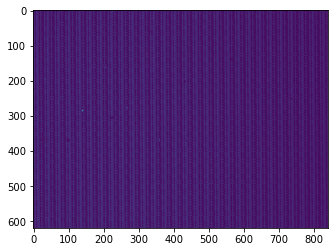

Shape of the filter array: torch.Size([620, 840, 45])


In [2]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


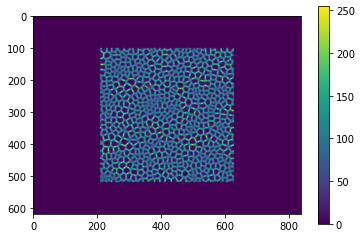

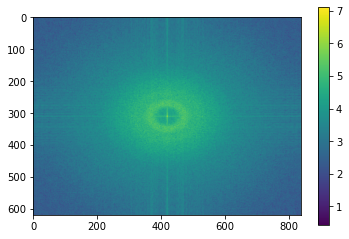

In [3]:
# PSF

datafolder = '../PSF'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

## Filter magnitude

In [85]:
import gaussplat_wrong_filtermag as gpw

In [86]:
# Ground truth parameters -- must be floats
muy = 0.0
mux = 0.0
mul = 0.0
sigy = 5.
sigx = 5.
sigl = 5.
amplitude = 1
NY, NX, NL = m.shape

In [94]:
# Create gaussian object and 3D array
g = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)

# Wrong library
gw = gpw.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[xw,yw,coordsw] = gpw.createMeshGrid(NX, NY)

In [95]:
g_filt = gp.createGaussFilter(sigx, sigy, coords, NX, NY, amplitude)
gw_filt = gpw.createGaussFilter(sigx, sigy, coordsw, NX, NY, amplitude)

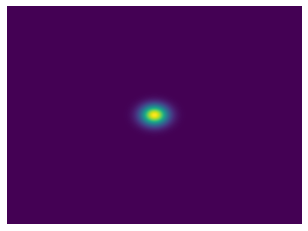

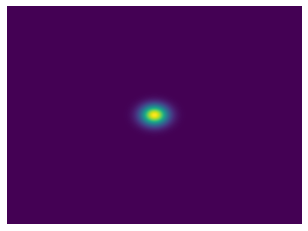

In [96]:
plt.imshow(g_filt, cmap='viridis')  # Add cmap for better visualization (optional)
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(gw_filt.detach().numpy(), cmap='viridis')  # Add cmap for better visualization (optional)
plt.axis('off')  # Turn off axis labels
plt.show()

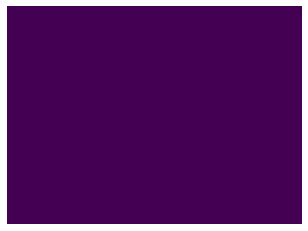

MSE:  0.0


In [97]:
# Measurement
g_meas = gp.forwardSingleGauss(g, NX, NY, NL, h, m)
g_meas = g_meas/torch.norm(g_meas)

gw_meas = gpw.forwardSingleGauss(gw, NX, NY, NL, h, m)
gw_meas = gw_meas/torch.norm(gw_meas)

meas_error = g_meas - gw_meas

plt.figure()
plt.imshow(meas_error.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

mse = torch.norm(meas_error)
print("MSE: ", mse.detach().numpy())

## Filter Phase

In [112]:
import gaussplat_wrong_filterphase as gpw

In [113]:
importlib.reload(gpw)

<module 'gaussplat_wrong_filterphase' from '../Libraries/gaussplat_wrong_filterphase.py'>

In [135]:
# Ground truth parameters -- must be floats
muy = 0.7
mux = 0.0
mul = 0.0
sigy = 5.
sigx = 5.
sigl = 5.
amplitude = 1
NY, NX, NL = m.shape

In [136]:
# Create gaussian object and 3D array
g = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)

# Wrong library
gw = gpw.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[xw,yw,coordsw] = gpw.createMeshGrid(NX, NY)

In [137]:
g_filt_phase, _ = gp.createPhasorPadded(NX, NY, mux, muy)
gw_filt_phase, _ = gpw.createPhasorPadded(NX, NY, mux, muy)

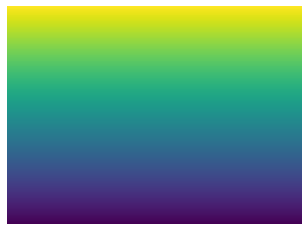

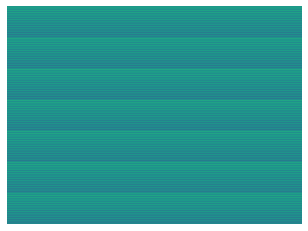

In [138]:
plt.imshow(np.angle(g_filt_phase))  # Add cmap for better visualization (optional)
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(np.angle(gw_filt_phase))  # Add cmap for better visualization (optional)
plt.axis('off')  # Turn off axis labels
plt.show()

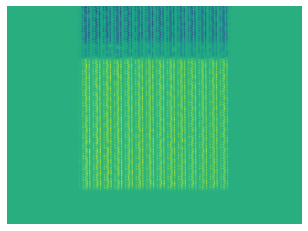

MSE:  1.2708257271536247


In [139]:
# Measurement
g_meas = gp.forwardSingleGauss(g, NX, NY, NL, h, m)
g_meas = g_meas/torch.norm(g_meas)

gw_meas = gpw.forwardSingleGauss(gw, NX, NY, NL, h, m)
gw_meas = gw_meas/torch.norm(gw_meas)

meas_error = g_meas - gw_meas

plt.figure()
plt.imshow(meas_error.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

mse = torch.norm(meas_error)
print("MSE: ", mse.detach().numpy())

## Wavelength

In [167]:
import gaussplat_wrong_wavelength as gpw

In [168]:
importlib.reload(gpw)

<module 'gaussplat_wrong_wavelength' from '../Libraries/gaussplat_wrong_wavelength.py'>

In [169]:
# Ground truth parameters -- must be floats
muy = 0.0
mux = 0.0
mul = 0.0
sigy = 5.
sigx = 5.
sigl = 5.
amplitude = 1
NY, NX, NL = m.shape

In [170]:
# Create gaussian object and 3D array
g = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)

# Wrong library
gw = gpw.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[xw,yw,coordsw] = gpw.createMeshGrid(NX, NY)

In [171]:
g_lam, _ = gp.createWVFilt(mul, sigl, NL, m)
gw_lam, _ = gpw.createWVFilt(mul, sigl, NL, m)

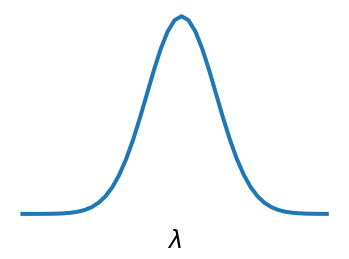

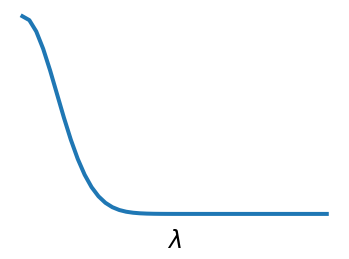

In [185]:
plt.plot(g_lam, lw = 4)  # Add cmap for better visualization (optional)
plt.gca().tick_params(left=False, labelleft=False,  # Remove y-axis ticks and labels
                      bottom=False, labelbottom=False)  # Remove x-axis ticks
for spine in plt.gca().spines.values():  # Remove the plot box
    spine.set_visible(False)

plt.xlabel("$\lambda$", fontsize=24)
plt.show()

plt.plot(gw_lam, lw = 4)  # Add cmap for better visualization (optional)
plt.gca().tick_params(left=False, labelleft=False,  # Remove y-axis ticks and labels
                      bottom=False, labelbottom=False)  # Remove x-axis ticks
for spine in plt.gca().spines.values():  # Remove the plot box
    spine.set_visible(False)

plt.xlabel("$\lambda$", fontsize=24)
plt.show()

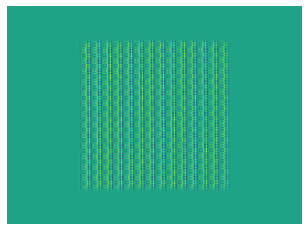

MSE:  1.2168360822373252


In [186]:
# Measurement
g_meas = gp.forwardSingleGauss(g, NX, NY, NL, h, m)
g_meas = g_meas/torch.norm(g_meas)

gw_meas = gpw.forwardSingleGauss(gw, NX, NY, NL, h, m)
gw_meas = gw_meas/torch.norm(gw_meas)

meas_error = g_meas - gw_meas

plt.figure()
plt.imshow(meas_error.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

mse = torch.norm(meas_error)
print("MSE: ", mse.detach().numpy())

## Zero-padding

In [275]:
import gaussplat_wrong_zp as gpw

In [276]:
importlib.reload(gpw)

<module 'gaussplat_wrong_zp' from '../Libraries/gaussplat_wrong_zp.py'>

In [283]:
# Ground truth parameters -- must be floats
muy = 0.0
mux = 400.0
mul = 0.0
sigy = 5.
sigx = 5.
sigl = 5.
amplitude = 1
NY, NX, NL = m.shape

In [284]:
# Create gaussian object and 3D array
g = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)

# Wrong library
gw = gpw.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[xw,yw,coordsw] = gpw.createMeshGrid(NX, NY)

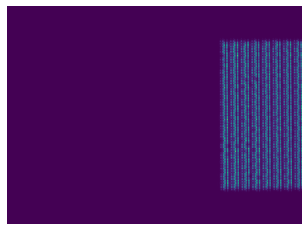

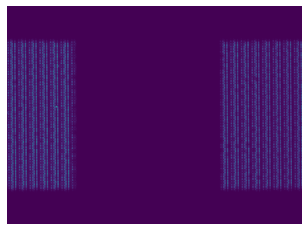

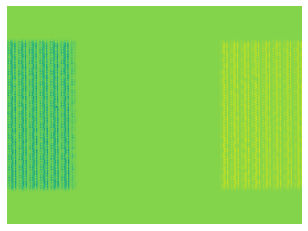

MSE:  0.8115358470796834


In [285]:
# Measurement
g_meas = gp.forwardSingleGauss(g, NX, NY, NL, h, m)
g_meas = g_meas/torch.norm(g_meas)

gw_meas = gpw.forwardSingleGauss(gw, NX, NY, NL, h, m)
gw_meas = gw_meas/torch.norm(gw_meas)

meas_error = g_meas - gw_meas

plt.figure()
plt.imshow(g_meas.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

plt.figure()
plt.imshow(gw_meas.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

plt.figure()
plt.imshow(meas_error.detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.show() 

mse = torch.norm(meas_error)
print("MSE: ", mse.detach().numpy())